<a href="https://colab.research.google.com/github/hpazerf/tweepy-2020-election/blob/main/2020_Election_Analysis_using_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install tweepy
!pip install nltk
!pip install vaderSentiment

In [ ]:
import tweepy
import pandas as pd
import string
import re
import nltk
import numpy as np
import time
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

from collections import defaultdict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Variables that contains the credentials to access Twitter API
ACCESS_TOKEN = ''
ACCESS_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET = ''


# Setup access to API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth,wait_on_rate_limit=True)
    return api


# Create API object
api = connect_to_twitter_OAuth()

# Task A: Using Tweepy API to get Tweets

In [ ]:
# Creating a dataframe to place the tweet information into
tweets_df = pd.DataFrame(columns = ['tweet_id','user_id' ,'user_name' ,
                                    'user_screenname' ,'text','user_location' ,
                                    'coordinates' ,'created_at','source',
                                    'retweets','favorites', 'retweeted_status'])

In [ ]:
text_query = '2020 US Election'
count = 2500
t0 = time.process_time()
try:
  # Creation of query method using parameters
  tweets = tweepy.Cursor(api.search,q=text_query, tweet_mode='extended').items(count) #tweet_mode extended allows us to get the full tweet
  
  # Pulling information from tweets iterable object
  tweets_list=[]
  for tweet in tweets:
    #if (not tweet.retweeted) and ('RT @' not in tweet.text) and (i != 3200):
    tweet_id = tweet.id
    user_id = tweet.user.id
    user_name = tweet.user.name
    user_screenname = tweet.user.screen_name
    # text = tweet.full_text# utf-8 text of tweet
    user_location = tweet.user.location # The location that the user put down when creating an account
    coordinates = tweet.coordinates
    created_at = tweet.created_at # utc time tweet created
    source = tweet.source # utility used to post tweet
    retweets = tweet.retweet_count # number of times this tweet retweeted
    favorites = tweet.favorite_count # number of time this tweet liked
    retweeted_status = 'retweeted_status' in dir(tweet)
    ##getting tweet text

    if 'retweeted_status' in dir(tweet):
      text = tweet.retweeted_status.full_text
    else:
      text = tweet.full_text
    # Placing tweet information into a dataframe
    tweets_df.loc[len(tweets_df)] = [tweet_id,user_id,user_name,user_screenname,
                                     text,user_location,coordinates,created_at,
                                     source,retweets,favorites, retweeted_status]

  # Creation of dataframe from tweets list
  # Add or remove columns as you remove tweet information
 
except BaseException as e:
    print('failed on_status,',str(e))
    time.sleep(3)
t1 = time.process_time()
total = t1-t0
print("Time to run = "+str(total) +" s")

Time to run = 19.879457701000007 s


In [ ]:
# Saving the information about the tweets into a csv file
tweets_df.to_csv("tweets.csv")

# Preprocessing Data

In [ ]:
# Grabbing the csv files 
# tweet_master is all the tweets collected in one file
# Replaced Issues is the csv file used to process the data and replace similiar issues
# Location replaced is the csv file to find cities or abbreviations to change to state name
master_tweets_df = pd.read_csv('master_tweets.csv')
replace_df = pd.read_csv('replaced_issues.csv',header=None)
location_df = pd.read_csv('location_replaced.csv',header=None)

###Replacing location names

In [ ]:
# Replacing all cities or state abbreviations with the state name
# MI -> michigan
# Detroit -> michigan
for i in range((location_df.shape[0])):
  replacee=location_df.loc[i,0].lower()
  replacedby=location_df.loc[i,1].lower()
  if i == 0:
    master_tweets_df["replaced_location"]= master_tweets_df["user_location"].str.replace(rf"\b{replacee}\b", replacedby, case = False)
  else:
    master_tweets_df["replaced_location"]= master_tweets_df["replaced_location"].str.replace(rf"\b{replacee}\b", replacedby, case = False)

### Replacing similar issues

In [ ]:

# Replacing all similar issue into same word
# coronavirus -> covid
for i in range((replace_df.shape[0])):
  replacee=replace_df.loc[i,0].lower()
  replacedby=replace_df.loc[i,1].lower()
  if i == 0:
    master_tweets_df["replaced_text"]= master_tweets_df["text"].str.replace(rf"\b{replacee}\b", replacedby, case = False)
  else:
    master_tweets_df["replaced_text"]= master_tweets_df["replaced_text"].str.replace(rf"\b{replacee}\b", replacedby, case = False)

### Word Freq

In [ ]:
# Count Word Frequency
# Finding the most common words in the tweets and using this to find issues
word_freq = {}
for i in range((master_tweets_df.shape[0])):
  if type(master_tweets_df.loc[i,'replaced_text']) == str: 
    user_tweet=master_tweets_df.loc[i,'replaced_text'].lower()
    match_pattern = re.findall(r'\b[a-z]{3,20}\b', user_tweet)
    for word in match_pattern:
      if word not in stop_words:
        count = word_freq.get(word,0)
        word_freq[word] = count + 1
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
sorted=word_freq_df.sort_values(by=['Frequency'], ascending=False)

In [ ]:
sorted.to_csv("trial_sorted_word_freq.csv")


# Task B: Issue Frequencies

In [ ]:
# Selected issues based on common words found in word frequency list and common issues discussed in the political perspective 
issues =['covid', 'vaccine', 'jobs', 
          'gun-rights', 'trade', 'GDP', 'debt', 
         'student-debt', 'healthcare', 'immigration', 'climate-change',
         'economy', 'child-care','child', 'school', 'abortion', 
         'race-inequality', 'LGBT', 'white-supremacy', 'corrupt', 'employment', 
         'supreme-court', 'russia', 'email', 'protest']
# Candidates for the US 2020 Presidential election
candidates = ['biden', 'trump']

In [ ]:
# Searching through all the tweets to count the number times each issue appears in all the tweets
# If the issue is found it increments the value in the dictionary for the issue
# Looking specifically through the preprocessed tweets (replaced_text)
issue_dict ={}
for issue in issues:
  for i in range((master_tweets_df.shape[0])):
    if type(master_tweets_df.loc[i,'replaced_text']) == str: 
      user_tweet=master_tweets_df.loc[i,'replaced_text'].lower()
      if (issue.lower() in user_tweet):
        if issue not in issue_dict:
          issue_dict[issue] = 1
        else:
          issue_dict[issue] += 1
# Making the dictionary into a dataframe
issue_df = pd.DataFrame.from_dict(issue_dict, orient='index', columns=['Frequency'])
issue_df.sort_values(by=['Frequency'], ascending=False).head(20)

,Frequency
covid,2535
protest,1095
russia,1053
corrupt,637
email,528
economy,407
supreme-court,179
GDP,116
race-inequality,108
immigration,106


In [ ]:
highest_issues=issue_df.sort_values(by=['Frequency'], ascending=False).head(4).index.to_list()
highest_issues

['covid', 'protest', 'russia', 'corrupt']

# Task C: Lift Analysis

In [ ]:
# Searching through all the tweets to count the number times each candidate appears in all the tweets
# If the candidate is found it increments the value in the dictionary for the candidate
# Looking specifically through the preprocessed tweets (replaced_text)
candidate_dict ={}
for candidate in candidates:
  for i in range((master_tweets_df.shape[0])):
    if type(master_tweets_df.loc[i,'replaced_text']) == str: 
      user_tweet=master_tweets_df.loc[i,'replaced_text'].lower()
      if (candidate.lower() in user_tweet):
        if candidate not in candidate_dict:
          candidate_dict[candidate] = 1
        else:
          candidate_dict[candidate] += 1
# Making the dictionary into a dataframe
candidate_df = pd.DataFrame.from_dict(candidate_dict, orient='index', columns=['Frequency'])
candidate_df.sort_values(by=['Frequency'], ascending=False).head()

,Frequency
trump,7661
biden,3145


In [ ]:
# Creating a dictionary of all possible combinations of the candidates and issues
i= 0
lift_dict={}
for issue in highest_issues:
  for candidate in candidates:
    i+=1
    lift_dict[i] = []
    lift_dict[i].append(issue)
    lift_dict[i].append(candidate)

# Creating three seperate lists
# The first two lists splits the different combinations of the issues and candidate into two seperate lists
# The third list intitilzes 0 to account for the frequency of the combination of the candiate and issue appearing together in a tweet
pair_issue=[]
pair_candidate=[]
freq=[]
for pair in lift_dict.values():
    pair_issue.append(pair[0])
    pair_candidate.append(pair[1])
    freq.append(0)

# Searching through all the tweets to count the number times the combination of the issue and candidate appears in all the tweets
# If the pair is found it increments the value in the freq list for the the pair
# Looking specifically through the preprocessed tweets (replaced_text)
for i in range(len(pair_issue)):
    for j in range((master_tweets_df.shape[0])):
      if type(master_tweets_df.loc[j,'replaced_text']) == str: 
        user_tweet=master_tweets_df.loc[j,'replaced_text'].lower()
        if ((pair_issue[i].lower() in user_tweet) and (pair_candidate[i].lower() in user_tweet)):
          num=freq[i]+1
          freq[i]=num
          
# Placing each list into the same dataframe
pair_freq_df= pd.DataFrame(pair_issue, columns = ['Issue'])
pair_freq_df["Candidate"]=pair_candidate
pair_freq_df["Frequency"]=freq

In [ ]:
pair_freq_df

,Issue,Candidate,Frequency
0,covid,biden,594
1,covid,trump,1850
2,protest,biden,3
3,protest,trump,1047
4,russia,biden,566
5,russia,trump,132
6,corrupt,biden,530
7,corrupt,trump,74


In [ ]:
# Finding the lift ratio for each pair
# Using the three dataframes to get the values required to calculate the lift ratio
# Pair Freq dataframe: the issue, the candidate, and the frequency of both appearing together
# Issue dataframe: The issue and the frequency of the issue appearing
# Candidate dataframe: The candidate and the frequency of the candidate appearing
# Going through the pair freq dataframe to find which issue and which candidate are being looked at currently
# Using the information for the pair freq dataframe each separate frequency is found on the issue and candidate dataframe 

# The amount of tweets collected
samples = master_tweets_df.shape[0]
lift_ratio_list = []
for i in range((pair_freq_df.shape[0])):
  pair_freq = pair_freq_df.loc[i,'Frequency']
  issue_pair = pair_freq_df.loc[i,'Issue']
  candidate_pair = pair_freq_df.loc[i,'Candidate']
  A_freq = issue_df.loc[issue_pair].to_numpy()[0]
  B_freq = candidate_df.loc[candidate_pair].to_numpy()[0]
  lift_ratio = (samples*pair_freq)/(A_freq*B_freq)
  lift_ratio_list.append(lift_ratio)

# Creating a dataframe that shows the issue and the candidate and their lift ratio
lift_ratio_df= pd.DataFrame(pair_issue, columns = ['Issue'])
lift_ratio_df["Candidate"]=pair_candidate
lift_ratio_df["Lift Ratio"]=lift_ratio_list

In [ ]:
# Pivoting the dataframe to show a side by side comparison of the candidates and the issues
lift_ratio_df.pivot(index='Issue', columns='Candidate', values='Lift Ratio')

Candidate,biden,trump
Issue,,
corrupt,4.519920,0.259073
covid,1.272925,1.627509
protest,0.014883,2.132368
russia,2.919997,0.279560


# Task D: Sentiment Analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()
stopwords_set = set(stopwords.words("english"))

issue_candidate = {'trump': ['covid', 'protest'],
                   'biden': ['covid', 'russia', 'corrupt']}

score_dict = defaultdict(list) ##dict that will hold issue-candidate and relevant dataframe indeces

for candidate, issue_list in issue_candidate.items():
  for issue in issue_list:
    for j in range(len(master_tweets_df)):
      user_tweet = master_tweets_df.loc[j, 'replaced_text'].lower()
      if (issue in user_tweet) and (candidate in user_tweet):
        ###exclude stop word from tweet
        cleaned_tweet = [word for word in user_tweet.split() if not word in stopwords_set]

        for word in cleaned_tweet:
          if candidate in word:
            candidate_index = cleaned_tweet.index(word)
          if issue in word:
            issue_index = cleaned_tweet.index(word)
        
        
        sub_tweet = ""

        for x in range(np.minimum(candidate_index, issue_index) - 4, np.maximum(candidate_index, issue_index) + 5):
          if x >= 0 and x < len(cleaned_tweet):
            try:
              sub_tweet += cleaned_tweet[x] + ' '
            except IndexError:
              pass
        ## We think the above method reflects the sentiment better because it considers the window between the candidate and the issue

        score = analyzer.polarity_scores(sub_tweet)['compound']
        
        key = candidate + '-' + issue
        score_dict[key].append(score)

In [ ]:
sentiment_df = pd.DataFrame()
for key, value in score_dict.items():
  temp = pd.DataFrame({'candidate-issue': key, 'avg_sentiment': np.mean(value)}, index=[0])
  sentiment_df = pd.concat([sentiment_df, temp])

sentiment_df.reset_index(inplace=True, drop=True)
sentiment_df

,candidate-issue,avg_sentiment
0,trump-covid,0.025946
1,trump-protest,-0.000762
2,biden-covid,-0.538340
3,biden-russia,-0.793695
4,biden-corrupt,-0.829942


# Task E: Network Visualization

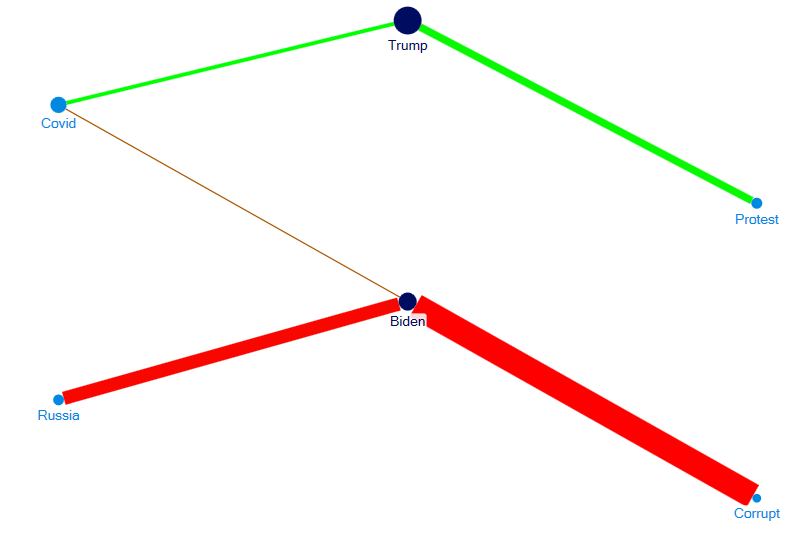

In [ ]:
from IPython.display import Image
Image(filename=r'visualization.png')

# Task F: Sentiment Analysis in battleground states (MI, PA, WI)

In [ ]:
analyzer = SentimentIntensityAnalyzer()
stopwords_set = set(stopwords.words("english"))

score_dict_states = defaultdict(list) ##dict that will hold issue-candidate and relevant dataframe indeces


for candidate, issue_list in issue_candidate.items():
  for issue in issue_list:
    for j in range(len(master_tweets_df)):
      if (type(master_tweets_df.loc[j,'replaced_text']) == str) and type(master_tweets_df.loc[j,'replaced_location']) == str: 
        user_tweet = master_tweets_df.loc[j, 'replaced_text'].lower()
        location = master_tweets_df.loc[j,'replaced_location'].lower()
        if (issue in user_tweet) and (candidate in user_tweet) and ('battleground state' in location):
          ###exclude stop word from tweet
          words_without_stopwords = [word for word in user_tweet.split() if not word in stopwords_set]
          cleaned_tweet = [word for word in user_tweet.split() if not word in stopwords_set]

          for word in cleaned_tweet:
            if candidate in word:
              candidate_index = cleaned_tweet.index(word)
            if issue in word:
              issue_index = cleaned_tweet.index(word)
          
          
          sub_tweet = ""

          for x in range(np.minimum(candidate_index, issue_index) - 2, np.maximum(candidate_index, issue_index) + 3):
            if x >= 0 and x < len(cleaned_tweet):
              try:
                sub_tweet += cleaned_tweet[x] + ' '
              except IndexError:
                pass
          ## We think the above method reflects the sentiment better because it considers the window between the candidate and the issue

          score = analyzer.polarity_scores(sub_tweet)['compound']
          
          key = candidate + '-' + issue
          score_dict_states[key].append(score)

In [ ]:
sentiment_df_states = pd.DataFrame()
for key, value in score_dict_states.items():
  temp = pd.DataFrame({'candidate-issue': key, 'avg_sentiment': np.mean(value)}, index=[0])
  sentiment_df_states = pd.concat([sentiment_df_states, temp])

sentiment_df_states.reset_index(inplace=True, drop=True)
sentiment_df_states

,candidate-issue,avg_sentiment
0,trump-covid,0.04599
1,trump-protest,0.00000
2,biden-covid,-0.58590
3,biden-russia,-0.84020
4,biden-corrupt,-0.84020
